In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames[:1]:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/renewdata/sample_submission.csv
/kaggle/input/renewdata/test/641.png
/kaggle/input/renewdata/train/가구수정/11.png
/kaggle/input/renewdata/train/터짐/94.png
/kaggle/input/renewdata/train/들뜸/48.png
/kaggle/input/renewdata/train/피스/48.png
/kaggle/input/renewdata/train/창틀,문틀수정/11.png
/kaggle/input/renewdata/train/녹오염/11.png
/kaggle/input/renewdata/train/석고수정/48.png
/kaggle/input/renewdata/train/훼손/1231.png
/kaggle/input/renewdata/train/꼬임/173.png
/kaggle/input/renewdata/train/울음/11.png
/kaggle/input/renewdata/train/걸레받이수정/173.png
/kaggle/input/renewdata/train/틈새과다/4.png
/kaggle/input/renewdata/train/오염/173.png
/kaggle/input/renewdata/train/곰팡이/94.png
/kaggle/input/renewdata/train/이음부불량/11.png
/kaggle/input/renewdata/train/면불량/94.png
/kaggle/input/renewdata/train/반점/1.png
/kaggle/input/renewdata/train/오타공/94.png
/kaggle/input/renewdata/train/몰딩수정/94.png


## ConvNeXT 모델
https://americanoisice.tistory.com/121

In [3]:
import gc
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import StratifiedKFold, train_test_split

import torch 
import torchvision as tv
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from sklearn.metrics import f1_score

from timm.data import create_transform

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
import glob
data = pd.DataFrame({"path":glob.glob("/kaggle/input/renewdata/train/*/*")})
data

data["label"] = data["path"].apply(lambda x: x.split("/")[-2])
data

,path,label
0,/kaggle/input/renewdata/train/가구수정/11.png,가구수정
1,/kaggle/input/renewdata/train/가구수정/4.png,가구수정
2,/kaggle/input/renewdata/train/가구수정/9.png,가구수정
3,/kaggle/input/renewdata/train/가구수정/1.png,가구수정
4,/kaggle/input/renewdata/train/가구수정/2.png,가구수정
...,...,...
3452,/kaggle/input/renewdata/train/몰딩수정/19.png,몰딩수정
3453,/kaggle/input/renewdata/train/몰딩수정/110.png,몰딩수정
3454,/kaggle/input/renewdata/train/몰딩수정/26.png,몰딩수정
3455,/kaggle/input/renewdata/train/몰딩수정/79.png,몰딩수정


In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data["class"] = le.fit_transform(data["label"])

In [7]:
from torch.utils.data import Dataset, DataLoader, IterableDataset

class CassavaLeafDiseaseDataset(IterableDataset):
    def __init__(self, df, transform):
        super(CassavaLeafDiseaseDataset).__init__()
        self.df = df
        self.transform = transform
        self.start = 0
        self.end = len(df)
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        fpath = self.df.iloc[i, 0]
        img = self.transform(Image.open(fpath).convert('RGB'))
        class_label_int = self.df.iloc[i, -1]
        return img, class_label_int
    
    ## iterable dataset 
    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None:  # single-process data loading, return the full iterator
            iter_start = self.start
            iter_end = self.end
        else:  # in a worker process
            # split workload
            per_worker = int(math.ceil((self.end - self.start) / float(worker_info.num_workers))) #num_workers : 
            worker_id = worker_info.id
            iter_start = self.start + worker_id * per_worker
            iter_end = min(iter_start + per_worker, self.end)
        return map(self.__getitem__, range(iter_start, iter_end))

Iterable Dataset
https://inmoonlight.github.io/2021/02/21/PyTorch-IterableDataset/

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

df = {}
train_df, test_df = train_test_split(
    data, stratify=data.label, train_size=0.66, random_state=0
)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [10]:
datasets = {}
datasets['train'] = CassavaLeafDiseaseDataset(train_df, T.ToTensor())
datasets['test'] = CassavaLeafDiseaseDataset(test_df, T.ToTensor())

In [11]:
!pip install timm

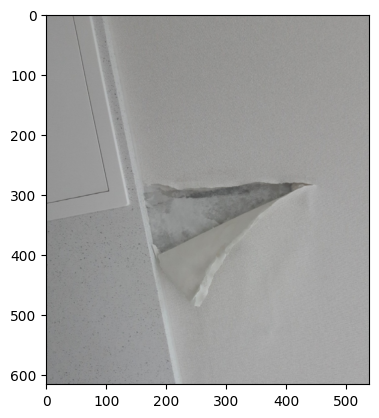

In [14]:
def show_image(data):
    img, label = data
    plt.imshow(img.permute(1, 2, 0))
    plt.show()
show_image(datasets['train'][4])

In [16]:
datasets['train'].transform = create_transform(input_size=384, is_training=True, )#interpolation='bicubic', mean=mean, std=std
datasets['test'].transform = create_transform(input_size=384, is_training=True, )

In [17]:
batch_size = 16
dataloaders = {}
dataloaders['train'] = DataLoader(datasets['train'], batch_size, num_workers=2, pin_memory=False, shuffle=False)
dataloaders['test'] = DataLoader(datasets['test'], batch_size, num_workers=2, pin_memory=False)

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
from torchvision import models

model_ft = models.convnext_tiny(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:01<00:00, 92.1MB/s] 


In [20]:
model_ft

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

모델 뒷부분 Fine tuning